In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score,GridSearchCV, KFold, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA, TruncatedSVD

# Data Loading

In [3]:
df = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')
testdf = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')

# EDA

In [4]:
df.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [5]:
df.info() # there are 2 null values in Recipe_Review colulmn

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [6]:
df.describe()
num = ['ID','RecipeNumber','RecipeCode','UserReputation','CreationTimestamp','ReplyCount','ThumbsUpCount','ThumbsDownCount','Rating','BestScore']

In [7]:
df['Rating'].value_counts() # distribution of target variable : The Target class is highly imbalanced

Rating
5    10371
0     1272
4     1241
3      368
1      210
2      174
Name: count, dtype: int64

<Axes: xlabel='RecipeNumber', ylabel='count'>

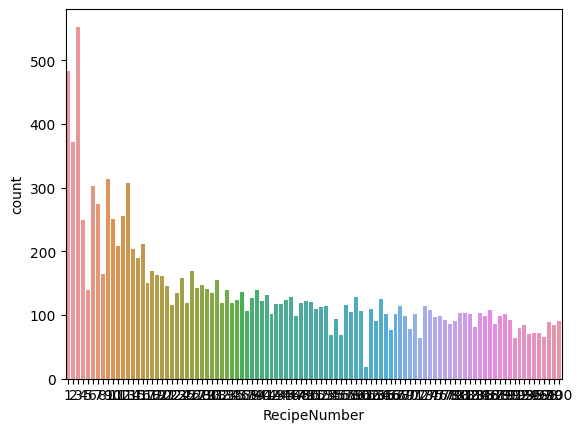

In [8]:
df['RecipeNumber'].value_counts() #distrubution of no of reviews based on raning of the Recipe
sns.countplot(x=df['RecipeNumber']) # We observer that the top recipies in ranking have large number of reviews and as the rank goes down the reviews also become less

In [9]:
df.value_counts('UserID') #max no of reviews by singele user is 20
df.value_counts('UserReputation') #few useres have very high reputation most useres have 1 reputation, There are 118 reviews with 0 user rep. Why?
df[df['UserReputation'] == 0]['Rating'].value_counts() #total users with 0 rep = 111

Rating
5    85
0    14
4    10
1     4
2     3
3     2
Name: count, dtype: int64

In [10]:
df['Date'] = df['CreationTimestamp'].apply(lambda x: pd.Timestamp(x,unit='s'))

In [11]:
df['RecipeCode'].value_counts()

RecipeCode
2832     553
14299    483
3309     372
42083    313
32480    307
        ... 
35766     68
34347     65
3683      64
1821      64
17022     19
Name: count, Length: 100, dtype: int64

In [12]:
df.sort_values('Date') #Data is from 2021-02-11 09:22:16 to 2022-10-14 14:00:35
df[df['RecipeCode']==2832].sort_values('BestScore')

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review,Date
5203,44,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_428456,u_1oKWX4a8A6MMPbGnDbt7LeyC59u,GaryPhillips,10,1630527302,0,7,39,1,34,At a loss how this recipe became a contest win...,2021-09-01 20:15:02
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...,2021-06-03 10:49:17
8750,496,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_176966,u_1oKX4RMQcgj0x0LGerTk14pszEG,nmcneal,1,1622717225,0,0,0,5,100,I have made this soup for the family and for c...,2021-06-03 10:47:05
8730,346,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_180556,u_1oKX2nQsOhOSf25rLzdcVAZ2PDl,funkyla,1,1622717245,0,0,0,5,100,I just made this tonight and it taste great. I...,2021-06-03 10:47:25
8716,712,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_362374,u_1oKVaTJc2XK2A8lvPuM3UB0jZY1,nvthiele,1,1622718150,0,0,0,5,100,We enjoy this recipe but felt the cheese conte...,2021-06-03 11:02:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7858,28,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_1xmTfleOfAP8S6elIch5UpuiI2T,u_Rhl9Bx3Gwnvm,cwbuff2,1,1630959369,0,35,0,4,828,I see some reviews by the inevitable health na...,2021-09-06 20:16:09
11028,18,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_246uLQ6MDmZo1Ji68gWRnfKoiUY,u_F7qQvdhfuhfG,Val460,1,1642963300,0,15,1,5,835,Made this for our Football Sunday in Snowy Ups...,2022-01-23 18:41:40
3921,4,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_2EYJhFS6QZik7CC30jaDSEJCTaA,u_PbObJrhRttq3,James569,1,1662766701,0,12,0,5,848,<p>I downloaded this recipe after recently rec...,2022-09-09 23:38:21
4686,29,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_1xETpSVM9yR69ApipJFaCeraf5k,u_pTSG77yt7Ax9,CJR58,1,1629919430,0,69,9,5,863,This looks delicious. If I want to make it in...,2021-08-25 19:23:50


In [13]:
df['day'] = df['Date'].apply(lambda x : x.day)
df['month'] = df['Date'].apply(lambda x : x.month)
df['yeay'] = df['Date'].apply(lambda x : x.year)
df['time'] = df['Date'].apply(lambda x : x.time().hour)
df['dow'] = df['Date'].apply(lambda x : x.weekday())

In [14]:
df.groupby('time').count()['Rating'] # most reviwes are posted between 10 to 11am everyday
df.groupby('day').count()['Rating']  # most reviwes are posted on 3rd every month
df.groupby('month').count()['Rating'] # most reviwes are posted in June
#df.groupby('yeay').count()['Rating'] # most reviwes are posted in 2021

month
1        68
2       132
3        22
4        51
5        63
6     12891
7        71
8        75
9        99
10       81
11       42
12       41
Name: Rating, dtype: int64

In [15]:
df[(df['yeay'] == 2021)&(df['month'] == 6) & (df['day'] == 3) & ((df['time'] == 10) | (df['time'] ==11))] ##More than 12,000 reviews were posted on 3rd June 2021 between 10 am and 12pm

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,...,ThumbsDownCount,Rating,BestScore,Recipe_Review,Date,day,month,yeay,time,dow
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,...,0,5,100,great recipe! I have made them just as written...,2021-06-03 10:44:38,3,6,2021,10,3
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,...,1,5,100,This is an easy and quick recipe that is great...,2021-06-03 10:57:32,3,6,2021,10,3
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,...,0,3,100,I think I was looking for something extra spec...,2021-06-03 10:49:17,3,6,2021,10,3
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,...,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...,2021-06-03 11:04:20,3,6,2021,11,3
6,96,17,36450,Fluffy Key Lime Pie,sp_aUSaElGf_36450_c_352563,u_1oKVpLXFmg8oIk8lHGHV0mcZb53,bybybaby,1,1622718115,0,...,0,4,100,Very good and summer good.,2021-06-03 11:01:55,3,6,2021,11,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13631,115,98,11767,Quick Cream of Mushroom Soup,sp_aUSaElGf_11767_c_127710,u_1oKVbHjirkAIWwTjbt9dWyqENo2,elbay,1,1622716969,0,...,0,5,100,Delicious!! Very easy to make! One minor chang...,2021-06-03 10:42:49,3,6,2021,10,3
13632,372,6,21444,Favorite Chicken Potpie,sp_aUSaElGf_21444_c_196030,u_1oKXoBnyJ2ocquNYwAhs19LMSrA,PauletteInhofe,1,1622717329,0,...,0,5,100,I made this pie for my family and they loved i...,2021-06-03 10:48:49,3,6,2021,10,3
13633,87,37,20170,Taco Lasagna,sp_aUSaElGf_20170_c_359338,u_1oKbGr5o9tj0mQl1rkVqzWnE481,Barbaralarkin,1,1622718089,0,...,0,5,100,Very tasty!,2021-06-03 11:01:29,3,6,2021,11,3
13634,48,63,24886,Chicken and Dumplings,sp_aUSaElGf_24886_c_175514,u_1oKWD7Dqjmc0oYHdW8Vm3fzhxJW,SammyPrissy,1,1622717192,0,...,0,5,100,I have made this numerous times. It&#39;s so ...,2021-06-03 10:46:32,3,6,2021,10,3


In [16]:
#sns.pairplot(df[num])###looking for corelations and the distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Rating', ylabel='Count'>

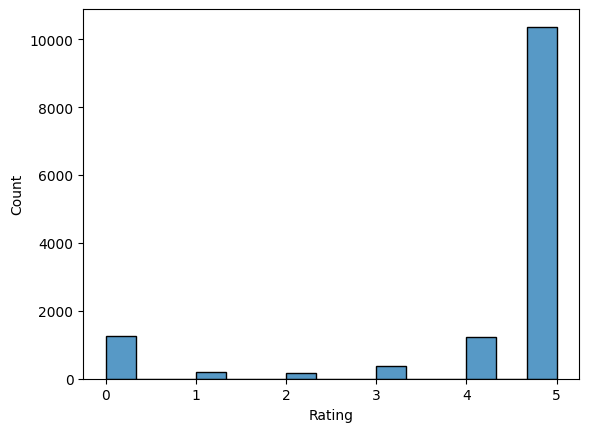

In [17]:
sns.histplot(df['Rating'])

In [18]:
#text = html.unescap
#svc
#decision tree
#lgbm 

# Drop Null Values

In [19]:
df.dropna(axis=0,inplace=True)

# Feature Selection

In [20]:
df.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore',
       'Recipe_Review', 'Date', 'day', 'month', 'yeay', 'time', 'dow'],
      dtype='object')

In [21]:
X = df[['RecipeNumber' , 'UserReputation', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'BestScore', 'day', 'month', 'yeay', 'time', 'dow']]
Y = df['Rating']

In [22]:
test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

features = fit.transform(X)
# Summarize selected features
print(features[0:5,:])


[1.487e+03 2.583e+02 2.985e+02 7.307e+02 1.457e+04 5.558e+03 1.469e+02
 1.420e+00 5.314e-04 7.754e+00 1.479e+00]
[[ 71   0   0   0 100]
 [ 88   0   0   1 100]
 [  3   0   0   0 100]
 [ 50   0   0   0 100]
 [ 12   0   0   0 100]]


In [23]:

ratings = df[['RecipeCode','RecipeNumber','RecipeName','Recipe_Review','BestScore','Rating','UserReputation','ReplyCount','ThumbsUpCount', 'ThumbsDownCount','day','time']]

# Data Cleaning

In [24]:

stopw = ['i','me','my', 'myself', 'we', 'our', 'ours','ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have','has','had', 'having','do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again','further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won',
 "won't", 'wouldn', "wouldn't"]
def clean(x):
    
    words = ''.join([char for char in x if char not in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~1234567890'])
    return ' '.join([word for word in words.split() if word.lower() not in stopw])
    #return words
#print(clean('sachit!!,,..'))
ratings['Cleaned'] = ratings['Recipe_Review'].apply(lambda x: clean(str(x)))
ratings.shape

/tmp/ipykernel_18/802609679.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['Cleaned'] = ratings['Recipe_Review'].apply(lambda x: clean(str(x)))


(13634, 13)

In [25]:
ratings.drop('Recipe_Review',axis=1,inplace=True)
ratings['len'] = ratings['Cleaned'].apply(lambda x: len(x))
ratings1 = ratings[ratings['len']<400]

/tmp/ipykernel_18/1610105560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings.drop('Recipe_Review',axis=1,inplace=True)
/tmp/ipykernel_18/1610105560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['len'] = ratings['Cleaned'].apply(lambda x: len(x))


In [26]:
pd.options.display.max_colwidth = 500
x = ratings1.drop('Rating',axis=1)
y = ratings1['Rating']
x_tot,x_test,y_tot,y_test = train_test_split(x,y,test_size = 0.2,random_state=42,stratify=y)
x_train,xval,y_train,yval = train_test_split(x_tot,y_tot)

In [27]:
numfeature = ['RecipeNumber','BestScore','UserReputation','ThumbsUpCount', 'ThumbsDownCount','day','time','ReplyCount']
cat = ['RecipeCode']
colt = ColumnTransformer([('minmax',MinMaxScaler(),numfeature),('ohe',OneHotEncoder(),cat),('tfidf',TfidfVectorizer(max_features=2500,ngram_range=(1,3)),'Cleaned'),('tfidf2',TfidfVectorizer(),'RecipeName')])

#pipe = Pipeline([('trans',colt),('xgb',XGBClassifier())])

#pipe.fit(x_train,y_train)

In [28]:
np.random.seed=42

In [29]:
pipe1a = Pipeline([('trans',colt),('xgb',XGBClassifier(random_state=42))])
pipe1a.fit(x_train,y_train)
pipe1a.score(x_test,y_test)

0.7702753677857412

In [30]:
pipe2a = Pipeline([('trans',colt),('lr',LogisticRegression(max_iter=1000))])
pipe2a.fit(x_train,y_train)
score2 = pipe2a.score(x_test,y_test)

In [31]:
pipe3 = Pipeline([('trans',colt),('rfc',RandomForestClassifier())])
pipe3.fit(x_train,y_train)
pipe3.score(x_test,y_test)

0.7695209354960393

In [32]:
pipe4 = Pipeline([('trans',colt),('LGB',(LGBMClassifier(random_state=42)))])
pipe4.fit(x_train,y_train)
score4 = pipe4.score(x_test,y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42132
[LightGBM] [Info] Number of data points in the train set: 7952, number of used features: 1706
[LightGBM] [Info] Start training from score -2.375881
[LightGBM] [Info] Start training from score -4.177158
[LightGBM] [Info] Start training from score -4.396211
[LightGBM] [Info] Start training from score -3.601281
[LightGBM] [Info] Start training from score -2.444487
[LightGBM] [Info] Start training from score -0.267432


In [33]:
pipe1b = Pipeline([('trans',colt),('pca',TruncatedSVD(n_components=200,random_state=42)),('xgb',XGBClassifier(random_state=42))])
pipe1b.fit(x_train,y_train)
pipe1b.score(x_test,y_test)

0.7714070162202943

In [34]:
# pipe2a = Pipeline([('trans',colt),('pca',TruncatedSVD(random_state=42,n_components=200)),('lr',LogisticRegression(max_iter=1000))])
# pipe2a.fit(x_train,y_train)
# pipe2a.score(x_test,y_test)

In [35]:
# pipe3b = Pipeline([('trans',colt),('pca',TruncatedSVD(random_state=42,n_components=200)),('rfc',RandomForestClassifier(random_state=42))])
# pipe3b.fit(x_train,y_train)
# pipe3b.score(x_test,y_test)

# **HyperParameter Tuning - Model 1**

In [36]:
Kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)

In [37]:
# params1 = {'xgb__objective' :['binary:logistic','multi: softmax'],'xgb__num_class':[6],'xgb__class_weight':['None'],'xgb__eta':[0.1],'xgb__max_depth':[3,5,7,9,12],'xgb__gamma' :[0.1],'xgb__scale_pos_weight' : [1]}
# #params1f ={'xgb__objective' :['binary:logistic','multi: softmax'],'xgb__num_class':[6],'xgb__class_weight':['None','balanced'],'xgb__eta':[0.1],'xgb__max_depth':[3,5,7,9],'xgb__gamma' :[0.1],'xgb__scale_pos_weight' : [1]}
# gs1 = GridSearchCV(pipe1b,param_grid=params1,cv=Kfold,scoring='accuracy',verbose=4)
# gs1.fit(x_train,y_train)
# gs1.best_estimator_.score(xval,yval)

In [38]:
# gs1.best_estimator_.score(x_test,y_test)

In [39]:
# gs1.best_estimator_.score(x_test,y_test)

In [40]:
# params1a = {'xgb__objective' :['binary:logistic'],'xgb__num_class':[6],'xgb__class_weight':['None'],'xgb__eta':[0.1],'xgb__max_depth':[5,7,9],'xgb__min_child_weight' :[1,3,5],'xgb__gamma' :[0],'xgb__scale_pos_weight' : [1]}
# #params1f ={'xgb__objective' :['binary:logistic','multi: softmax'],'xgb__num_class':[6],'xgb__class_weight':['None','balanced'],'xgb__eta':[0.1],'xgb__max_depth':[3,5,7,9],'xgb__gamma' :[0.1],'xgb__scale_pos_weight' : [1]}
# gs1a = GridSearchCV(pipe1a,param_grid=params1a,cv=Kfold,scoring='accuracy',verbose=4)
# gs1a.fit(x_train,y_train)
# gs1a.best_estimator_.score(xval,yval)

In [41]:
# gs1a.best_params_

In [42]:
# params1a = {'xgb__objective' :['binary:logistic'],'xgb__num_class':[6],'xgb__class_weight':['None'],'xgb__eta':[0.1],'xgb__max_depth':[7],'xgb__min_child_weight' :[3],'xgb__gamma' :[0,0.1,0.2,0.3,0.4],'xgb__scale_pos_weight' : [1]}
# #params1f ={'xgb__objective' :['binary:logistic','multi: softmax'],'xgb__num_class':[6],'xgb__class_weight':['None','balanced'],'xgb__eta':[0.1],'xgb__max_depth':[3,5,7,9],'xgb__gamma' :[0.1],'xgb__scale_pos_weight' : [1]}
# gs1a = GridSearchCV(pipe1a,param_grid=params1a,cv=Kfold,scoring='accuracy',verbose=4)
# gs1a.fit(x_train,y_train)
# gs1a.best_estimator_.score(xval,yval) # gamma =0.3

In [43]:
# params1a = {'xgb__objective' :['binary:logistic'],'xgb__num_class':[6],'xgb__class_weight':['None'],'xgb__eta':[0.1],'xgb__max_depth':[7],'xgb__min_child_weight' :[3],'xgb__gamma' :[0.3],'xgb__scale_pos_weight' : [1],'xgb__subsample':[i/10.0 for i in range(6,10)],
#  'xgb__colsample_bytree':[i/10.0 for i in range(6,10)]}
# gs1a = GridSearchCV(pipe1a,param_grid=params1a,cv=Kfold,scoring='accuracy',verbose=4)
# gs1a.fit(x,y)

In [44]:
# gs1a.best_params_

{'xgb__class_weight': 'None',
 'xgb__colsample_bytree': 0.6,
 'xgb__eta': 0.1,
 'xgb__gamma': 0.3,
 'xgb__max_depth': 7,
 'xgb__min_child_weight': 3,
 'xgb__num_class': 6,
 'xgb__objective': 'binary:logistic',
 'xgb__scale_pos_weight': 1,
 'xgb__subsample': 0.8}

In [45]:
# params1a = {'xgb__objective' :['binary:logistic'],'xgb__num_class':[6],'xgb__class_weight':['None'],'xgb__eta':[0.1],'xgb__max_depth':[7],'xgb__min_child_weight' :[3],'xgb__gamma' :[0.3],'xgb__scale_pos_weight' : [1],'xgb__subsample':[0.8],
#   'xgb__colsample_bytree':[0.6]}
# #params1a = {'xgb__objective' :['binary:logistic']}
# gs1a = GridSearchCV(pipe1a,param_grid=params1a,cv=Kfold,scoring='accuracy',verbose=4)
# gs1a.fit(x,y)
# score1 = gs1a.score(xval,yval)

In [46]:
params1a = {'xgb__objective' :['binary:logistic'],'xgb__num_class':[6],'xgb__class_weight':['None'],'xgb__eta':[0.1],'xgb__max_depth':[7],'xgb__min_child_weight' :[3],'xgb__gamma' :[0.3],'xgb__scale_pos_weight' : [1],'xgb__subsample':[0.8],
 'xgb__colsample_bytree':[0.6]}
gs1a = GridSearchCV(pipe1a,param_grid=params1a,cv=Kfold,scoring='accuracy',verbose=4)
gs1a.fit(x_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:34:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END xgb__class_weight=None, xgb__colsample_bytree=0.6, xgb__eta=0.1, xgb__gamma=0.3, xgb__max_depth=7, xgb__min_child_weight=3, xgb__num_class=6, xgb__objective=binary:logistic, xgb__scale_pos_weight=1, xgb__subsample=0.8;, score=0.774 total time=  14.8s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:35:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END xgb__class_weight=None, xgb__colsample_bytree=0.6, xgb__eta=0.1, xgb__gamma=0.3, xgb__max_depth=7, xgb__min_child_weight=3, xgb__num_class=6, xgb__objective=binary:logistic, xgb__scale_pos_weight=1, xgb__subsample=0.8;, score=0.773 total time=  15.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:35:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END xgb__class_weight=None, xgb__colsample_bytree=0.6, xgb__eta=0.1, xgb__gamma=0.3, xgb__max_depth=7, xgb__min_child_weight=3, xgb__num_class=6, xgb__objective=binary:logistic, xgb__scale_pos_weight=1, xgb__subsample=0.8;, score=0.775 total time=  14.5s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:35:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('minmax',
                                                                         MinMaxScaler(),
                                                                         ['RecipeNumber',
                                                                          'BestScore',
                                                                          'UserReputation',
                                                                          'ThumbsUpCount',
                                                                          'ThumbsDownCount',
                                                                          'day',
                                                                          'time',
                                                                          'ReplyCount']),
                                                                        ('ohe',
                                                                         OneHotEncoder(),
                                                                         ['RecipeCode']),
                                                                        ('tfidf',
                                                                         TfidfVectorizer(max_features=2...
                                                      num_parallel_tree=None,
                                                      objective='multi:softprob', ...))]),
             param_grid={'xgb__class_weight': ['None'],
                         'xgb__colsample_bytree': [0.6], 'xgb__eta': [0.1],
                         'xgb__gamma': [0.3], 'xgb__max_depth': [7],
                         'xgb__min_child_weight': [3], 'xgb__num_class': [6],
                         'xgb__objective': ['binary:logistic'],
                         'xgb__scale_pos_weight': [1],
                         'xgb__subsample': [0.8]},
             scoring='accuracy', verbose=4)

In [47]:
score1 = gs1a.score(xval,yval)

In [48]:
confusion_matrix(y_test,gs1a.predict(x_test))

array([[  17,    2,    0,    2,    2,  228],
       [   1,    8,    1,    2,    1,   28],
       [   3,    2,    0,    6,    3,   20],
       [   6,    2,    0,    2,    3,   58],
       [   3,    0,    1,    2,   13,  218],
       [  12,    2,    1,    1,    6, 1995]])

In [49]:
pd.Series(gs1a.predict(x)).value_counts()

5    12402
0      302
4      273
3      118
1      112
2       47
Name: count, dtype: int64

{'xgb__class_weight': 'None',
 'xgb__eta': 0.1,
 'xgb__gamma': 0.1,
 'xgb__max_depth': 9,
 'xgb__num_class': 6,
 'xgb__objective': 'binary:logistic',
 'xgb__scale_pos_weight': 1}

# Hyperparameter Tuning - Model 2

In [50]:
# Kfold = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)
# pipe3 = Pipeline([('trans',colt),('rfc',RandomForestClassifier(random_state=42))])
# pipe3.fit(x_train,y_train)
# pipe3.score(x_test,y_test)


In [51]:
# tr =[]
# val =[]
# for i in range(2,3000,50):
#     params3 = {'rfc__max_depth': ['None'],'rfc__min_samples_split':[i]}
#     gs3 = GridSearchCV(pipe3,param_grid=params3,cv=Kfold,scoring='accuracy',verbose=4)
#     gs3.fit(x_train,y_train)
#     tr.append(f1_score(y_train,gs3.predict(x_train),average='weighted'))
#     val.append(f1_score(y_test,gs3.predict(x_test),average='weighted'))
# sns.lineplot(x=np.arange(0,3000,50),y=tr,label='Train score')
# sns.lineplot(x=np.arange(0,3000,50),y=val,label='Test score')
# plt.xlabel('F1 weighted')
# plt.xlabel('min_samples_split')
# plt.title('F1weighted vs min_samples_split') # val score and train score intersects at min_samples_split =1500

In [52]:
# tr =[]
# val =[]
# for i in range(80,200,5):
#     params3 = {'rfc__max_depth': [100],'rfc__min_samples_split':[2],'rfc__max_leaf_nodes':[i]}
#     gs3 = GridSearchCV(pipe3,param_grid=params3,cv=Kfold,scoring='accuracy',verbose=4)
#     gs3.fit(x_train,y_train)
#     tr.append(accuracy_score(y_train,gs3.predict(x_train)))
#     val.append(accuracy_score(y_test,gs3.predict(x_test)))
# sns.lineplot(x=np.arange(80,200,5),y=tr,label='Train score')
# sns.lineplot(x=np.arange(80,200,5),y=val,label='Test score')
# plt.xlabel('Accuracy')
# plt.xlabel('max_leaf_nodes')
# plt.title('Accuracy vs max_leaf_nodes') # val score and train score intersects at max_leaf_nodes =165


In [53]:

# tr =[]
# val =[]
# for i in range(1,2000,50):
#     params3 = {'rfc__max_depth': [100],'rfc__min_samples_split':[2],'rfc__max_leaf_nodes':[165],'rfc__min_samples_leaf':[i]}
#     gs3 = GridSearchCV(pipe3,param_grid=params3,cv=Kfold,scoring='accuracy',verbose=4)
#     gs3.fit(x_train,y_train)
#     tr.append(f1_score(y_train,gs3.predict(x_train),average='weighted'))
#     val.append(f1_score(y_test,gs3.predict(x_test),average='weighted'))
# sns.lineplot(x=np.arange(1,2000,50),y=tr,label='Train score')
# sns.lineplot(x=np.arange(1,2000,50),y=val,label='Test score')
# plt.xlabel('Accuracy')
# plt.xlabel('min_samples_leaf')
# plt.title('Accuracy vs min_samples_leaf') # val score and train score intersects at min_samples_leaf =1


In [54]:

# tr =[]
# val =[]
# for i in range(1,200,10):
#     params3 = {'rfc__max_depth': [100],'rfc__min_samples_split':[2],'rfc__max_leaf_nodes':[165],'rfc__min_samples_leaf':[1],'rfc__n_estimators':[i]}
#     gs3 = GridSearchCV(pipe3,param_grid=params3,cv=Kfold,scoring='accuracy',verbose=4)
#     gs3.fit(x_train,y_train)
#     tr.append(f1_score(y_train,gs3.predict(x_train),average='weighted'))
#     val.append(f1_score(y_test,gs3.predict(x_test),average='weighted'))
# sns.lineplot(x=np.arange(1,200,10),y=tr,label='Train score')
# sns.lineplot(x=np.arange(1,200,10),y=val,label='Test score')
# plt.xlabel('Accuracy')
# plt.xlabel('n_estimators')
# plt.title('Accuracy vs n_estimators') # val score and train score intersects at n_estimators =30


In [55]:

# tr =[]
# val =[]
# for i in range(2,1000,50):
#     params3 = {'rfc__max_depth': [100],'rfc__min_samples_split':[2],'rfc__max_leaf_nodes':[165],'rfc__min_samples_leaf':[1],'rfc__n_estimators':[150],'rfc__max_features':[i]}
#     gs3 = GridSearchCV(pipe3,param_grid=params3,cv=Kfold,scoring='accuracy',verbose=4)
#     gs3.fit(x_train,y_train)
#     tr.append(gs3.score(x_train,y_train))
#     val.append(gs3.score(x_test,y_test))
# sns.lineplot(x=np.arange(2,1000,50),y=tr,label='Train score')
# sns.lineplot(x=np.arange(2,1000,50),y=val,label='Test score')
# plt.xlabel('Accuracy')
# plt.xlabel('max_features')
# plt.title('Accuracy vs max_features') # val score and train score intersects at max_features =500


In [56]:
Kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
tr =[]
val =[]
params3 = {'rfc__max_depth': [100],'rfc__min_samples_split':[2],'rfc__max_leaf_nodes':[160],'rfc__min_samples_leaf':[1],'rfc__n_estimators':[150],'rfc__max_features':[200]}
gs3 = GridSearchCV(pipe3,param_grid=params3,cv=Kfold,scoring='accuracy',verbose=4)
gs3.fit(x_train,y_train)
score3 = gs3.score(x_test,y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END rfc__max_depth=100, rfc__max_features=200, rfc__max_leaf_nodes=160, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=150;, score=0.767 total time=  11.3s
[CV 2/5] END rfc__max_depth=100, rfc__max_features=200, rfc__max_leaf_nodes=160, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=150;, score=0.769 total time=  10.9s
[CV 3/5] END rfc__max_depth=100, rfc__max_features=200, rfc__max_leaf_nodes=160, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=150;, score=0.770 total time=  11.1s
[CV 4/5] END rfc__max_depth=100, rfc__max_features=200, rfc__max_leaf_nodes=160, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=150;, score=0.767 total time=  10.7s
[CV 5/5] END rfc__max_depth=100, rfc__max_features=200, rfc__max_leaf_nodes=160, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=150;, score=0.769 total time=  10.5s


# Model Evaluation

<Axes: >

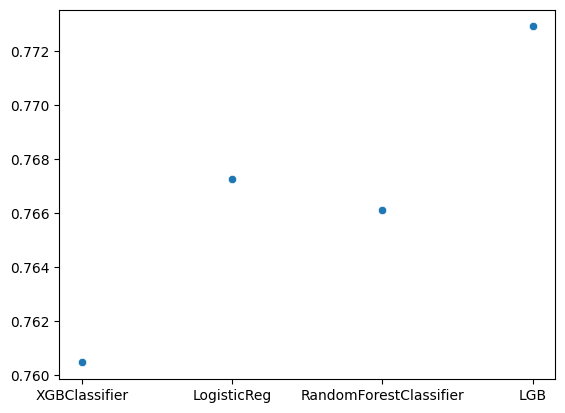

In [57]:
score = [score1,score2,score3,score4]
models =['XGBClassifier','LogisticReg','RandomForestClassifier','LGB']
sns.scatterplot(x = models,y=score)

In [58]:
model = XGBClassifier(objective ='binary:logistic',num_class= 6,class_weight= 'None',eta =0.1,max_depth=7,min_child_weight =3,gamma =0.3,scale_pos_weight =1,subsample =0.8,
 colsample_bytree=0.6)
pipe = Pipeline([('trans',colt),('xgb',model)])
pipe.fit(x,y)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:37:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('minmax', MinMaxScaler(),
                                                  ['RecipeNumber', 'BestScore',
                                                   'UserReputation',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount', 'day',
                                                   'time', 'ReplyCount']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['RecipeCode']),
                                                 ('tfidf',
                                                  TfidfVectorizer(max_features=2500,
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'Cleaned'),
                                                 ('tfidf2', TfidfVectorizer(),
                                                  'RecipeName')])),
                ('xg...
                               eval_metric=None, feature_types=None, gamma=0.3,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, ...))])

# Testing

In [59]:
testdf['Date'] = testdf['CreationTimestamp'].apply(lambda x: pd.Timestamp(x,unit='s'))
testdf['day'] = testdf['Date'].apply(lambda x : x.day)
testdf['month'] = testdf['Date'].apply(lambda x : x.month)
testdf['yeay'] = testdf['Date'].apply(lambda x : x.year)
testdf['time'] = testdf['Date'].apply(lambda x : x.time().hour)
testdf['dow'] = testdf['Date'].apply(lambda x : x.weekday())
testdf['Cleaned'] = testdf['Recipe_Review'].apply(lambda x: clean(str(x)))
testdf.drop('Recipe_Review',axis=1,inplace=True)
pred = gs1a.best_estimator_.predict(testdf)
pd.DataFrame(pred)
f = pd.DataFrame({'ID': np.arange(1,4547),'Rating' : pred})
f.to_csv('/kaggle/working/submission.csv',index=False)

In [60]:
f['Rating'].value_counts()

Rating
5    4364
0      76
4      46
1      30
3      26
2       4
Name: count, dtype: int64